# Productivity Feature Engineering & Optimization


## imports

In [7]:
# Cell 1: Environment check & imports
import os
import math
import joblib
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_validate, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Optional high-performance model
try:
    from xgboost import XGBRegressor
    XGBOOST_AVAILABLE = True
except Exception:
    XGBOOST_AVAILABLE = False

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("numpy:", np.__version__, "pandas:", pd.__version__)
print("XGBoost available:", XGBOOST_AVAILABLE)


numpy: 2.3.5 pandas: 2.3.3
XGBoost available: True


## Load data


In [8]:

DATA_PATH = "../data/employee_productivity.csv"
assert os.path.exists(DATA_PATH), f"Data not found at {DATA_PATH}"
df = pd.read_csv(DATA_PATH)
df_original = df.copy()  # keep a raw copy

print("Shape:", df.shape)
display(df.head())
display(df.info())
display(df.describe().T)


Shape: (300, 6)


,employee_id,login_time,logout_time,total_tasks_completed,weekly_absences,productivity_score
0,1,9,19,100,0,75
1,2,9,20,116,3,86
2,3,9,18,115,3,80
3,4,9,17,91,4,44
4,5,9,17,38,2,52


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   employee_id            300 non-null    int64
 1   login_time             300 non-null    int64
 2   logout_time            300 non-null    int64
 3   total_tasks_completed  300 non-null    int64
 4   weekly_absences        300 non-null    int64
 5   productivity_score     300 non-null    int64
dtypes: int64(6)
memory usage: 14.2 KB


None

,count,mean,std,min,25%,50%,75%,max
employee_id,300.0,150.500000,86.746758,1.0,75.75,150.5,225.25,300.0
login_time,300.0,8.506667,0.500791,8.0,8.00,9.0,9.00,9.0
logout_time,300.0,19.096667,1.428563,17.0,18.00,19.0,20.00,21.0
total_tasks_completed,300.0,67.286667,28.436007,20.0,42.75,66.0,91.25,119.0
weekly_absences,300.0,2.073333,1.409934,0.0,1.00,2.0,3.00,4.0
productivity_score,300.0,69.026667,18.037845,40.0,54.00,68.0,86.00,99.0


## Basic cleaning & target check

In [9]:
TARGET = 'productivity_score'
assert TARGET in df.columns, f"Target column '{TARGET}' not found"

# Remove exact duplicates
dups = df.duplicated().sum()
if dups:
    print("Dropping duplicate rows:", dups)
    df = df.drop_duplicates().reset_index(drop=True)

# Drop rows with missing target
missing_target = df[TARGET].isna().sum()
if missing_target:
    print("Dropping rows with missing target:", missing_target)
    df = df.dropna(subset=[TARGET])

# Quick sanity on impossible values (negative hours, negative experience)
for col in ['years_experience', 'hours_week', 'projects_completed', 'team_size', 'quality_score', 'error_rate']:
    if col in df.columns:
        negs = (df[col] < 0).sum()
        if negs:
            print(f"Found negative values in {col}: {negs}. Clipping to 0.")
            df.loc[df[col] < 0, col] = 0

print("After cleaning shape:", df.shape)


After cleaning shape: (300, 6)


## Data Split 

In [10]:

X = df.drop(columns=[TARGET])
y = df[TARGET].astype(float)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE
)
print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (240, 5) Test: (60, 5)


## Derive core features for baseline & optimized models

In [16]:

def add_basic_features(df):
    df = df.copy()

    # hours per day
    df['hours_per_day'] = df['logout_time'] - df['login_time']
    df['hours_per_day'] = df['hours_per_day'].clip(lower=0)

    # weekly working hours (assuming 5-day work week)
    df['hours_week'] = df['hours_per_day'] * 5

    # rename equivalent columns
    df['projects_completed'] = df['total_tasks_completed']

    # tasks per hour (efficiency)
    df['tasks_per_hour'] = df['projects_completed'] / df['hours_week'].replace(0, np.nan)
    df['tasks_per_hour'] = df['tasks_per_hour'].fillna(0)

    # absentee ratio
    df['absence_ratio'] = df['weekly_absences'] / 5.0

    # drop identifier
    if 'employee_id' in df.columns:
        df = df.drop(columns=['employee_id'])

    return df

X_train_fe = add_basic_features(X_train)
X_test_fe = add_basic_features(X_test)

print("Train FE shape:", X_train_fe.shape)
display(X_train_fe.head())


Train FE shape: (240, 9)


,login_time,logout_time,total_tasks_completed,weekly_absences,hours_per_day,hours_week,projects_completed,tasks_per_hour,absence_ratio
232,8,21,47,0,13,65,47,0.723077,0.0
59,8,19,54,3,11,55,54,0.981818,0.6
6,8,21,57,3,13,65,57,0.876923,0.6
185,8,18,87,3,10,50,87,1.740000,0.6
173,8,21,88,3,13,65,88,1.353846,0.6


## -- Baseline Model Linear Regression

In [17]:

baseline_features = [
    'projects_completed', 
    'hours_week',
    'weekly_absences',
    'tasks_per_hour',
    'absence_ratio'
]

baseline_features = [c for c in baseline_features if c in X_train_fe.columns]
print("Baseline features:", baseline_features)

num_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

preproc_baseline = ColumnTransformer([
    ('num', num_pipe, baseline_features)
], remainder='drop')

baseline_pipeline = Pipeline([
    ('preproc', preproc_baseline),
    ('model', LinearRegression())
])

baseline_pipeline.fit(X_train_fe[baseline_features], y_train)
y_pred_base = baseline_pipeline.predict(X_test_fe[baseline_features])

def regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return {'MAE': mae, 'RMSE': rmse, 'R2': r2}

baseline_results = regression_metrics(y_test, y_pred_base)
print("Baseline results:", baseline_results)


Baseline features: ['projects_completed', 'hours_week', 'weekly_absences', 'tasks_per_hour', 'absence_ratio']
Baseline results: {'MAE': 14.655837990791676, 'RMSE': 17.29801064687018, 'R2': -0.007060499027005784}


## Feature Engineering

In [18]:

def add_engineered_features(df):
    df = df.copy()
    
    df['work_intensity'] = df['hours_week'] / (df['weekly_absences'] + 1)

    df['efficiency_adjusted'] = df['tasks_per_hour'] * (1 - df['absence_ratio'])

    # Daily tasks distribution proxy
    df['tasks_per_day'] = df['projects_completed'] / 5.0

    # Interaction features
    df['tasks_x_hours'] = df['projects_completed'] * df['hours_week']
    df['tasks_x_absences'] = df['projects_completed'] * df['weekly_absences']

    return df

X_train_fe2 = add_engineered_features(X_train_fe)
X_test_fe2  = add_engineered_features(X_test_fe)

print("Enhanced FE shape:", X_train_fe2.shape)
display(X_train_fe2.head())


Enhanced FE shape: (240, 14)


,login_time,logout_time,total_tasks_completed,weekly_absences,hours_per_day,hours_week,projects_completed,tasks_per_hour,absence_ratio,work_intensity,efficiency_adjusted,tasks_per_day,tasks_x_hours,tasks_x_absences
232,8,21,47,0,13,65,47,0.723077,0.0,65.00,0.723077,9.4,3055,0
59,8,19,54,3,11,55,54,0.981818,0.6,13.75,0.392727,10.8,2970,162
6,8,21,57,3,13,65,57,0.876923,0.6,16.25,0.350769,11.4,3705,171
185,8,18,87,3,10,50,87,1.740000,0.6,12.50,0.696000,17.4,4350,261
173,8,21,88,3,13,65,88,1.353846,0.6,16.25,0.541538,17.6,5720,264


## Clustering Feature

In [19]:

cluster_cols = [
    'projects_completed',
    'hours_week',
    'tasks_per_hour',
    'weekly_absences'
]

scaler_cluster = StandardScaler()
train_cluster_scaled = scaler_cluster.fit_transform(X_train_fe2[cluster_cols])

kmeans = KMeans(n_clusters=4, random_state=RANDOM_STATE)
X_train_fe2['behavior_cluster'] = kmeans.fit_predict(train_cluster_scaled)

test_cluster_scaled = scaler_cluster.transform(X_test_fe2[cluster_cols])
X_test_fe2['behavior_cluster'] = kmeans.predict(test_cluster_scaled)

X_train_fe2['behavior_cluster'].value_counts()


behavior_cluster
3    75
0    67
1    50
2    48
Name: count, dtype: int64

## PCA

In [20]:
# PCA on numeric fields 

pca_cols = X_train_fe2.select_dtypes(include=[np.number]).columns.tolist()
pca_cols.remove('behavior_cluster')  # keep cluster separate

pt = PowerTransformer()
train_pca_input = pt.fit_transform(X_train_fe2[pca_cols])

pca = PCA(n_components=3, random_state=RANDOM_STATE)
train_pca_out = pca.fit_transform(train_pca_input)

for i in range(train_pca_out.shape[1]):
    X_train_fe2[f'pca_{i+1}'] = train_pca_out[:, i]

test_pca_input = pt.transform(X_test_fe2[pca_cols])
test_pca_out = pca.transform(test_pca_input)

for i in range(test_pca_out.shape[1]):
    X_test_fe2[f'pca_{i+1}'] = test_pca_out[:, i]

print("Added PCA features:", [f"pca_{i+1}" for i in range(train_pca_out.shape[1])])


Added PCA features: ['pca_1', 'pca_2', 'pca_3']


## Optimized Model (RandomForest + SelectKBest)

In [21]:
final_features = X_train_fe2.columns.tolist()
print("Final feature count:", len(final_features))

num_pipe2 = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

preproc2 = ColumnTransformer([
    ('num', num_pipe2, final_features)
], remainder='drop')

opt_pipeline = Pipeline([
    ('preproc', preproc2),
    ('select', SelectKBest(score_func=f_regression, k=12)),
    ('model', RandomForestRegressor(
        n_estimators=300,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

opt_pipeline.fit(X_train_fe2[final_features], y_train)
y_pred_opt = opt_pipeline.predict(X_test_fe2[final_features])

optimized_initial = regression_metrics(y_test, y_pred_opt)
print("Optimized initial results:", optimized_initial)


Final feature count: 18
Optimized initial results: {'MAE': 15.795617195767198, 'RMSE': 19.92894044045971, 'R2': -0.3366929571762245}


## Hyperparameter Tuning

In [22]:
# RandomizedSearchCV for optimized model

param_dist = {
    'select__k': [8, 10, 12, 15],
    'model__n_estimators': [200, 300, 500],
    'model__max_depth': [None, 5, 10, 20],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['sqrt', 'log2']
}

rs = RandomizedSearchCV(
    opt_pipeline,
    param_distributions=param_dist,
    scoring='neg_mean_squared_error',
    cv=3,
    n_iter=25,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)

rs.fit(X_train_fe2[final_features], y_train)
best_pipeline = rs.best_estimator_

y_pred_best = best_pipeline.predict(X_test_fe2[final_features])
optimized_best = regression_metrics(y_test, y_pred_best)

print("Best Params:", rs.best_params_)
print("Optimized tuned results:", optimized_best)


Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best Params: {'select__k': 15, 'model__n_estimators': 200, 'model__min_samples_leaf': 1, 'model__max_features': 'sqrt', 'model__max_depth': 5}
Optimized tuned results: {'MAE': 15.448386611256668, 'RMSE': 18.43076299446241, 'R2': -0.1432727976868584}


## Comparison table

In [23]:

comparison = pd.DataFrame({
    'Baseline': baseline_results,
    'Optimized Initial': optimized_initial,
    'Optimized Tuned': optimized_best
})

display(comparison.T.style.format("{:.4f}"))


,MAE,RMSE,R2
Baseline,14.6558,17.2980,-0.0071
Optimized Initial,15.7956,19.9289,-0.3367
Optimized Tuned,15.4484,18.4308,-0.1433


## Feature Importance Dashboard

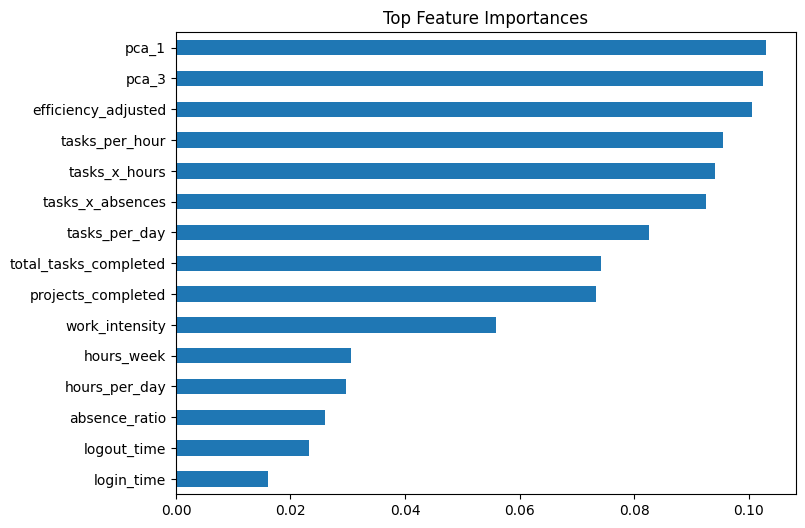

pca_1                    0.103116
pca_3                    0.102513
efficiency_adjusted      0.100623
tasks_per_hour           0.095514
tasks_x_hours            0.094071
tasks_x_absences         0.092624
tasks_per_day            0.082632
total_tasks_completed    0.074171
projects_completed       0.073378
work_intensity           0.055812
hours_week               0.030496
hours_per_day            0.029675
absence_ratio            0.026084
logout_time              0.023182
login_time               0.016108
dtype: float64

In [24]:

selector = best_pipeline.named_steps['select']
model = best_pipeline.named_steps['model']

selected_indices = selector.get_support(indices=True)
selected_feature_names = [final_features[i] for i in selected_indices]

importances = model.feature_importances_
fi = pd.Series(importances, index=selected_feature_names).sort_values(ascending=False)

plt.figure(figsize=(8,6))
fi.head(15).plot(kind='barh')
plt.title("Top Feature Importances")
plt.gca().invert_yaxis()
plt.show()

fi
